In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
from ipywidgets import interact

In [14]:
# I have to reshape the images due to my own computational limitations
images_setosa = np.array([np.array(Image.open("iris-setosa/"+image).resize((100,100))) for image in os.listdir("iris-setosa/")])

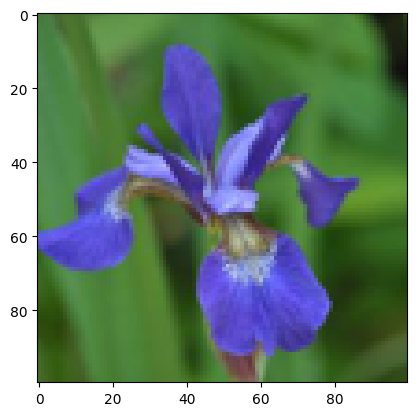

In [3]:
plt.imshow(images_setosa[0])
plt.show()

The images must be normalized by subtracting its mean and dividing by the standard deviation. Thus, the data is centered around $0$ and has variance $1$ along each dimension

In [4]:
def pre_normalize(X):
    X=X/255 #pixels in [0,1]
    mu=X.mean(axis=0)
    std=X.std(axis=0)
    Xbar=(X-mu)/std
    return Xbar,mu,std

In [5]:
def eig(S):
    values,vectors=np.linalg.eig(S)
    ind=np.argsort(values)[::-1] #sorts eigenvalues in descending order
    return values[ind], vectors[:,ind]  

In [6]:
def projection_matrix(B):
    return (B@np.linalg.inv(B.T@B)@B.T)

Let $N,D$ be the number of data points and the number of features (here, pixels), respectively. In this case $N\ll D$. With $\boldsymbol S=\frac1N\boldsymbol X\boldsymbol X^\top$ defined as the data covariance matrix, the result is a $D\times D$ matrix. Since variance is maximized along the directions defined by the eigenvectors of $\boldsymbol S$ associated with the highest eigenvalues and 
$$\boldsymbol S\_=\frac1N\boldsymbol X^\top\boldsymbol X\in\mathbb R^{N\times N}$$
has the same eigenvalues, it is more efficient to compute eigenvalues and eigenvectors of $\boldsymbol S\_$. That is, the eigenvector of $\boldsymbol S$ is given by $\boldsymbol X\boldsymbol c$, where $\boldsymbol c$ is an eigenvector of $\boldsymbol S\_$

**Important**: The mathematical description assumes $\boldsymbol X\in\mathbb R^{D\times N}$, while the dataset used in the code is a $N\times D$ matrix

In [7]:
def PCA(X,num_components):
    N=X.shape[0]
    S_=(X@X.T)/N
    values,vectors=eig(S_)
    B=X.T@np.real(vectors[:,:num_components])
    pmatrix = projection_matrix(B)
    return (pmatrix@X.T).T

In [8]:
def mse(X,reconst):
    return np.square(X-reconst).sum(axis=1).mean()

In [9]:
N=images_setosa.shape[0]
Xbar,mu,std=pre_normalize(images_setosa.reshape(N,100*100*3))

In [10]:
loss=list()
reconst=list()
for npc in range(1,67, 5):
    Xtilde=PCA(Xbar, npc)
    loss.append([mse(Xbar,Xtilde),npc])
    Xtilde_unnorm=(Xtilde*std+mu).reshape(N,100,100,3) #"unnormalized" such that it can be displayed as an image
    Xbar_unnorm=(Xbar*std+mu).reshape(N,100,100,3) #same here
    reconst.append(np.concatenate((Xbar_unnorm,Xtilde_unnorm),axis=2))
    

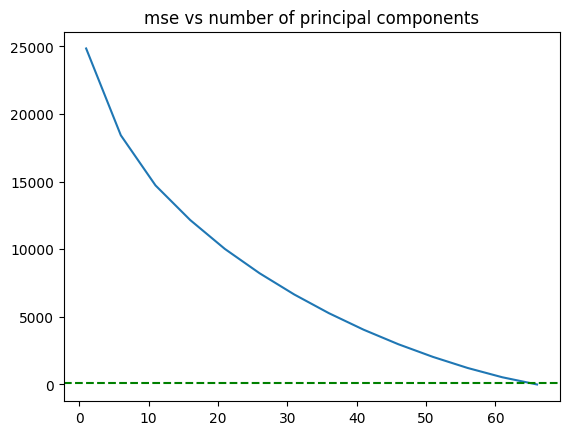

In [11]:
values=np.array(loss)
plt.plot(values[:,1],values[:,0])
plt.axhline(100, linestyle='--', color='g',)
plt.title("mse vs number of principal components")
plt.xlabel="num components"
plt.ylable="mse"
plt.show()

In [12]:
row1=np.zeros((100,7*100,3))
row2=np.zeros((100,7*100,3))
for i in range(7):
    #[:,100:200,:] since I concatenated the original image and the reconstruction for the interactive widget below
    row1[:,i*100:(i+1)*100,:]=reconst[i][0][:,100:200,:] 
    row2[:,i*100:(i+1)*100,:]=reconst[i+7][0][:,100:200,:]
pict=np.concatenate((row1,row2),axis=0)
        

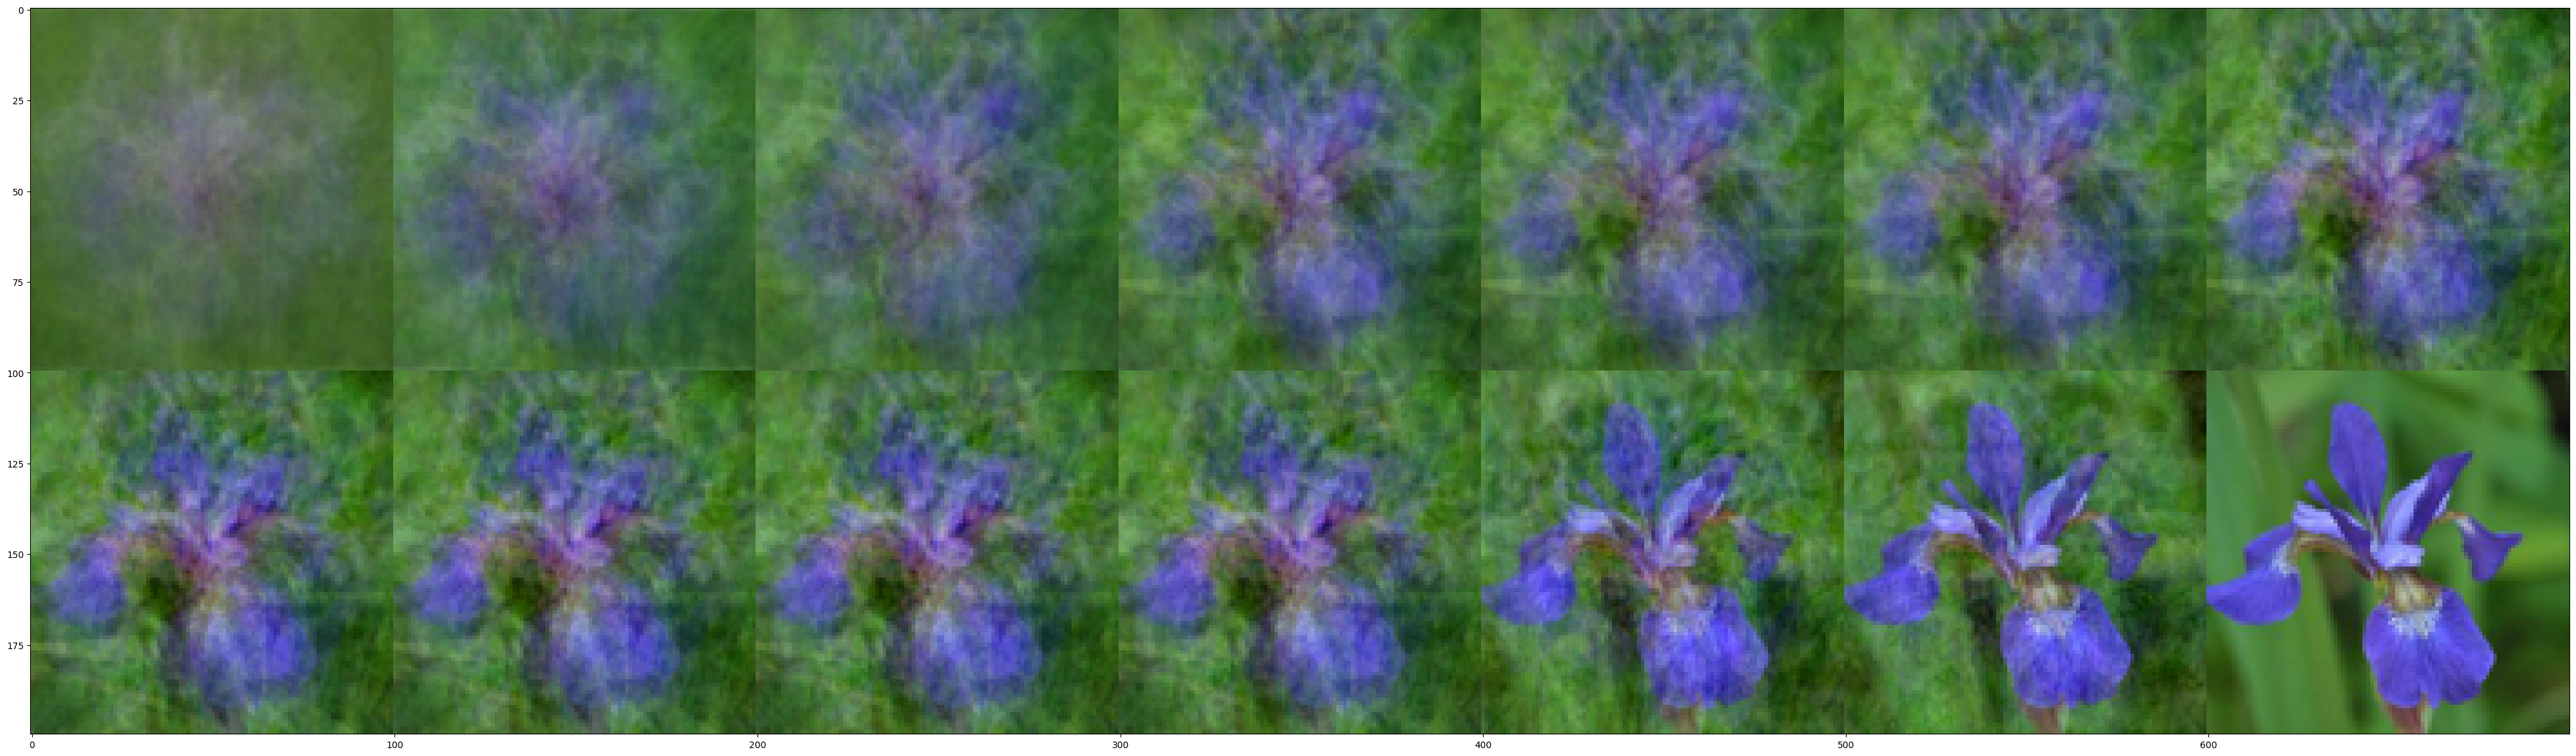

In [13]:
plt.figure(figsize=(50,50))
plt.imshow(np.clip(pict, 0, 1))
plt.show()

As seen from this plot, it requires a high number of principal components to make its features clearly visible. However, the image was sclaed down, leave less space for meaningful dimensionality reduction

An optional interactive view that allows to compare different images and their reconstructions

In [ ]:
%matplotlib widget
@interact(i=(0, 13))
def img_vs_construct(i=6):
    plt.figure(figsize=(4,4))
    image=reconst[i][0]
    print("Number of Principal Components: "+str(values[:,1][i]))
    plt.imshow( np.clip(image, 0, 1))
    plt.show()